### Building a Better (and More Realistic) Momentum Strategy
Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:
* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
    - Suppose A stock show consistant perform even small (0.5% or 1%) consider hqm 
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.
    - A stock which shows sudden or some month higher return (e.g. 10%) and remaning month lower 
----
The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by `short-term news` that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).
To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentile
* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation hqm often. It stands for high-quality-momentum stocks.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 
import talib

from scipy.stats import percentileofscore as score

In [2]:
from dataclasses import dataclass


@dataclass
class HQM:
  df: pd.DataFrame
  portfolio_value: float = 100000
  required_col = [
  'One Year Return', 
  'Six Month Return', 
  'Three Month Return', 
  'One Month Return'
  ]

  def get_stock_stats(self) -> pd.DataFrame:

    position_size = self.portfolio_value / len(self.df.columns)
    # floor division operator - to get the whole number of share
    number_of_share_to_buy = (position_size // self.df.iloc[-1]).astype('int64')

    changes = {}
    
    periods = {
        'year5': 252 * 5,
        'year3': 252 * 3,
        'year2': 252 * 2,
        'year1': 252,
        'month6': 21 * 6,
        'month3': 21 * 3,
        'month1': 21,
        'day30': 30,
        'day5': 5

    }
    
    max_value = self.df.max()
    min_value = self.df.min()
    latest_price = self.df.iloc[-1]

    changes['maxChanges'] = ((max_value - min_value ) / min_value) * 100
    
    for period_name, period_number in periods.items():
      # Validating if the datapoint are available for proper calculation
      if period_number >= len(self.df):
        continue
      past_price = self.df.iloc[-period_number]
      changes[f"{period_name}ChnagePercentage"] = (latest_price - past_price) / past_price * 100

    dataframe = pd.DataFrame.from_dict(changes)
    dataframe['latest Price'] = latest_price
    dataframe['Number of Share to buy'] = number_of_share_to_buy
    
    return dataframe


  def get_momentum_data(self) -> pd.DataFrame:
    df  = self.get_stock_stats()

    # Creating the empty dataframe
    new_df = pd.DataFrame()
    new_df_col = ['latest Price','Number of Share to buy' ,'year1ChnagePercentage','month6ChnagePercentage', 'month3ChnagePercentage', 'month1ChnagePercentage']


    for col in new_df_col:
      if col in df.columns:
        new_df[col] = df[col]
        if col not in ['latest Price', 'Number of Share to buy']:
          new_df[f'{col}Percentaile'] = np.nan
      else:
        new_df[col] = np.nan

    update_col = ['latest Price', 'Number of Share to buy', 'One Year Return', 'One Year Return Percentaile' ,'Six Month Return', 
                  'Six Month Return Percentaile','Three Month Return', 'Three Month Return Percentaile', 
                  'One Month Return', 'One Month Return Percentaile']
    
    new_df.columns = update_col  



    for col in self.required_col:
        changed_col = col 
        percentile_col = f'{col} Percentaile'
        new_df[percentile_col] = new_df[changed_col].rank(pct=True)
    
    return new_df

  def get_hqm_score(self):
    df = self.get_momentum_data()
    df['HQM Score'] = np.nan

    for row in df.index:
      for col in self.required_col:
          df.loc[row, 'HQM Score'] = np.mean(df.loc[row, col])

    return df


In [3]:
ticker_list =  ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'JPM', 'BAC', 'V', 'MA', 'PG', 'KO', 'WMT', 'PEP', 'JNJ', 'UNH', 'PFE', 'ABBV', 'LLY']
ticker_df = yf.download(ticker_list, start='2020-01-01', end='2023-12-31', interval='1D')['Adj Close']

[*********************100%%**********************]  18 of 18 completed


In [4]:
clsobj = HQM(ticker_df).get_hqm_score()
clsobj

,latest Price,Number of Share to buy,One Year Return,One Year Return Percentaile,Six Month Return,Six Month Return Percentaile,Three Month Return,Three Month Return Percentaile,One Month Return,One Month Return Percentaile,HQM Score
Ticker,,,,,,,,,,,
AAPL,192.024185,28,49.375937,0.722222,0.303417,0.444444,10.954616,0.722222,1.358255,0.555556,1.358255
ABBV,154.970001,35,-4.669043,0.277778,14.784096,0.722222,4.532884,0.500000,8.834891,0.888889,8.834891
AMZN,151.940002,36,80.494181,0.944444,16.679466,0.888889,17.364433,0.888889,4.004385,0.777778,4.004385
BAC,33.669998,165,1.599272,0.444444,15.308210,0.777778,26.104858,1.000000,10.429644,1.000000,10.429644
GOOG,140.929993,39,58.437322,0.833333,16.896148,0.944444,4.261297,0.444444,5.234464,0.833333,5.234464
JNJ,156.740005,35,-11.725610,0.111111,-4.046526,0.222222,1.024822,0.333333,1.344887,0.500000,1.344887
JPM,170.100006,32,27.683534,0.666667,16.022103,0.833333,18.313974,0.944444,8.982576,0.944444,8.982576
KO,58.930000,94,-7.849883,0.166667,-2.723674,0.333333,6.218459,0.555556,0.838470,0.333333,0.838470
LLY,582.919983,9,58.825132,0.888889,26.331751,1.000000,8.291071,0.666667,-1.373849,0.222222,-1.373849


In [5]:
clsobj.sort_values(by='HQM Score', ascending=False)

,latest Price,Number of Share to buy,One Year Return,One Year Return Percentaile,Six Month Return,Six Month Return Percentaile,Three Month Return,Three Month Return Percentaile,One Month Return,One Month Return Percentaile,HQM Score
Ticker,,,,,,,,,,,
BAC,33.669998,165,1.599272,0.444444,15.308210,0.777778,26.104858,1.000000,10.429644,1.000000,10.429644
JPM,170.100006,32,27.683534,0.666667,16.022103,0.833333,18.313974,0.944444,8.982576,0.944444,8.982576
ABBV,154.970001,35,-4.669043,0.277778,14.784096,0.722222,4.532884,0.500000,8.834891,0.888889,8.834891
GOOG,140.929993,39,58.437322,0.833333,16.896148,0.944444,4.261297,0.444444,5.234464,0.833333,5.234464
AMZN,151.940002,36,80.494181,0.944444,16.679466,0.888889,17.364433,0.888889,4.004385,0.777778,4.004385
TSLA,248.479996,22,103.973072,1.000000,-11.200061,0.111111,-1.240068,0.166667,3.498831,0.722222,3.498831
MA,426.510010,13,22.486436,0.555556,8.262265,0.500000,7.745359,0.611111,3.064066,0.666667,3.064066
V,260.350006,21,25.132178,0.611111,9.404549,0.555556,12.574048,0.777778,1.429801,0.611111,1.429801
AAPL,192.024185,28,49.375937,0.722222,0.303417,0.444444,10.954616,0.722222,1.358255,0.555556,1.358255


[*********************100%%**********************]  1 of 1 completed


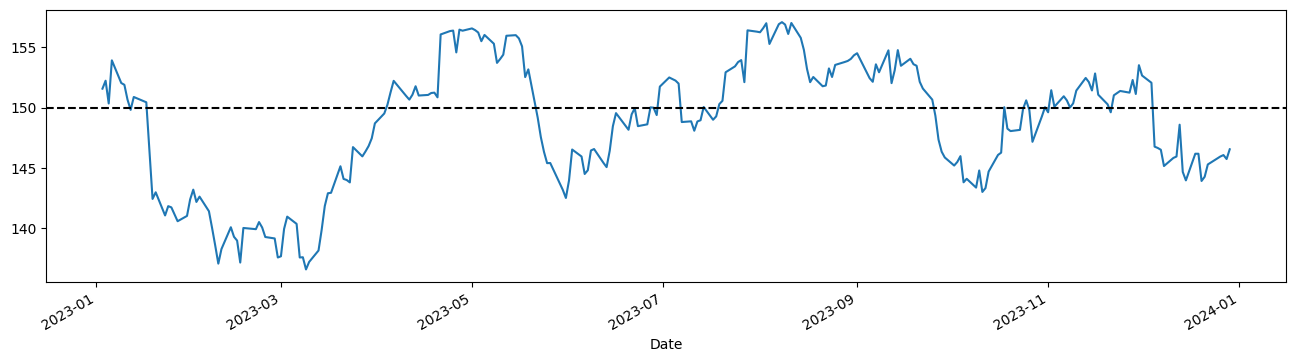

In [13]:
yf.download('PG', start='2023-01-01', end='2023-12-31', interval='1D')['Adj Close'].plot(figsize=(16,4))
plt.axhline(y=150, color='black', linestyle='--')